# Aim

In trying to build a simulation of atmospheric tip-tilts to correct using a Kalman-LQG controller, I've run into problems separating out tip and tilt from a phase screen, and in creating a specified tip or tilt in the focal plane intensity based on the phase at the pupil plane. This notebook demonstrates these problems.

In [1]:
# imports and setup

# I have hcipy as a submodule, so this import may vary
import sys
sys.path.append("..")
from hcipy.hcipy import *

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage, signal

pupil_size = 16
focal_samples = 8 # samples per lambda over D
focal_width = 8 # half the number of lambda over Ds
D = 10
D_magic = 1
wavelength = 500e-9 # m
f_sampling = 1000
T = 1
times = np.arange(0, T, 1/f_sampling)
pupil_grid = make_pupil_grid(pupil_size, D_magic)
focal_grid = make_focal_grid_from_pupil_grid(pupil_grid, focal_samples, focal_width, wavelength=wavelength)
prop = FraunhoferPropagator(pupil_grid, focal_grid)
aperture = circular_aperture(D_magic)(pupil_grid)
fried_parameter = 0.2 # meter
outer_scale = 20 # meter
velocity = 10 # meter/sec
Cn_squared = Cn_squared_from_fried_parameter(fried_parameter, wavelength)
layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared, outer_scale, velocity)

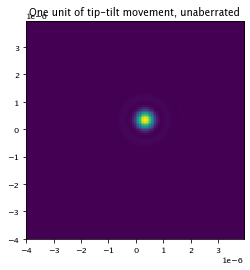

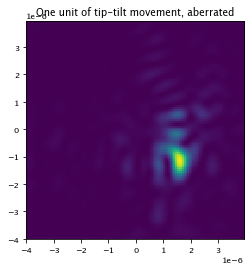

In [2]:
# first, I want to generate one unit of movement in both x and y

tt = [zernike(*ansi_to_zernike(i), D_magic)(pupil_grid) for i in (1, 2)] # tip-tilt phase basis
tt_weights = (1, 1) # number of lambda-over-Ds I want to move the CM
tt_wf = Wavefront(aperture * np.exp(1j * sum([w * z for w, z in zip(tt_weights, tt)])), wavelength)
tt_img = prop(tt_wf).intensity
tt_img_ab = prop(layer(tt_wf)).intensity
imshow_field(tt_img)
plt.title("One unit of tip-tilt movement, unaberrated")
plt.show()
imshow_field(tt_img_ab)
plt.title("One unit of tip-tilt movement, aberrated")
plt.show()

I want to see where the center of mass is for both of these. I expect it to be (8, 8) because I've specified unit weights for tip and tilt, and there's 8 pixels per lambda/D.

In [3]:
def center_of_mass(f):
    # takes in a Field, returns its CM.
    s = f.grid.shape[0]
    x, y = (n.flatten() for n in np.meshgrid(np.linspace(-s/2, s/2-1, s), np.linspace(-s/2, s/2-1, s)))
    return np.array((sum(f*x), sum(f*y)))/sum(f)

unaberrated_cm = center_of_mass(tt_img)
aberrated_cm = center_of_mass(tt_img_ab)
print("Unaberrated CM", unaberrated_cm)
print("Aberrated CM", aberrated_cm)

Unaberrated CM [4.86754191 4.86754191]
Aberrated CM [ 19.43948701 -10.72744741]


The aberrated CM is not recognizably anywhere near the unaberrated one, but that can likely be fixed after we simulate correcting all modes other than tip and tilt. The more pressing question is why the unaberrated CM is off by a factor of about 2. To fix that, I'm going to add a scaling factor to phases, but I don't know why this is necessary.

In [4]:
scale = focal_samples / unaberrated_cm[0]

In [5]:
# I want to simulate only TT not being controlled. First I'll use a ModalAOLayer.
corrected_layer = ModalAdaptiveOpticsLayer(layer, controlled_modes=ModeBasis(tt), lag=0)

Next, we run atmosphere tip-tilt in a loop so that its time-series and PSD can be examined. First, let's figure out dimensions: the output plane is in pixels that I can translate to lambda-over-Ds by scaling by focal_samples. lambda/D is rad: 1 lambda over D is about 500e-9/10 = 5e-8 = 10.313 mas, so one px is 1.29 mas. That seems a bit high, but okay.

Note that below I use a method that I wrote into ModalAdaptiveOpticsLayer.py to just get the correction for a mode basis, instead of the residual of the correction. This is equivalent (I think) to just having a ModeBasis with all modes that aren't tip and tilt.

In [6]:
def correction_for(self, wavelength):
    return self.transformation_matrix.dot(self.corrected_coeffs[0] / wavelength)

def correct_until(self, t):
    self.layer.evolve_until(t)

    if len(self.corrected_coeffs) > 0:
        coeffs = self.transformation_matrix_inverse.dot(self.correction_for(1))
    else:
        coeffs = self.transformation_matrix_inverse.dot(self.layer.phase_for(1))
    if len(self.corrected_coeffs) > self.lag:
        self.corrected_coeffs.pop(0)
    self.corrected_coeffs.append(coeffs)
    
ModalAdaptiveOpticsLayer.correction_for = correction_for
ModalAdaptiveOpticsLayer.correct_until = correct_until

In [7]:
conversion = (wavelength / D) * 206265000 / focal_samples

tt_cms = np.zeros((f_sampling * T, 2))
for n in range(f_sampling * T):
    corrected_layer.correct_until(times[n]) 
    
    wf = corrected_layer(Wavefront(aperture, wavelength))
    total_intensity = prop(wf).intensity
    tt_cms[n] = center_of_mass(total_intensity)
    
tt_cms *= conversion # pixels to mas

Text(0.5, 1.0, 'Atmospheric tip-tilts')

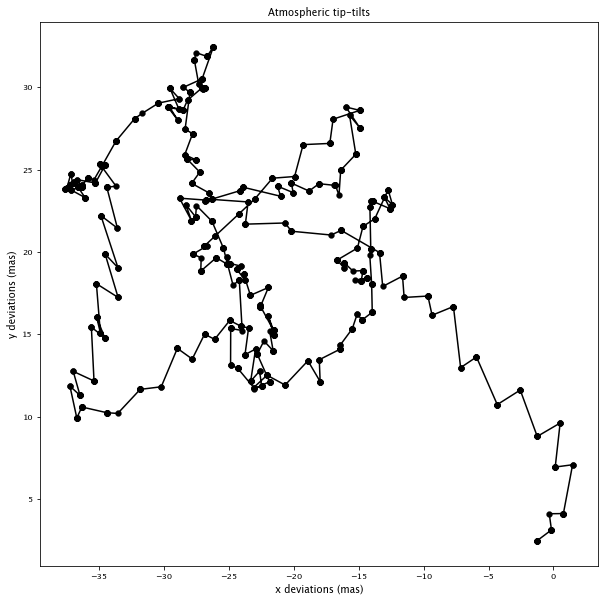

In [8]:
plt.figure(figsize=(10,10))
plt.plot(tt_cms[:,0], tt_cms[:,1], 'ko-')
plt.xlabel("x deviations (mas)")
plt.ylabel("y deviations (mas)")
plt.title("Atmospheric tip-tilts")

(1e-07, 1158.4760059399746)

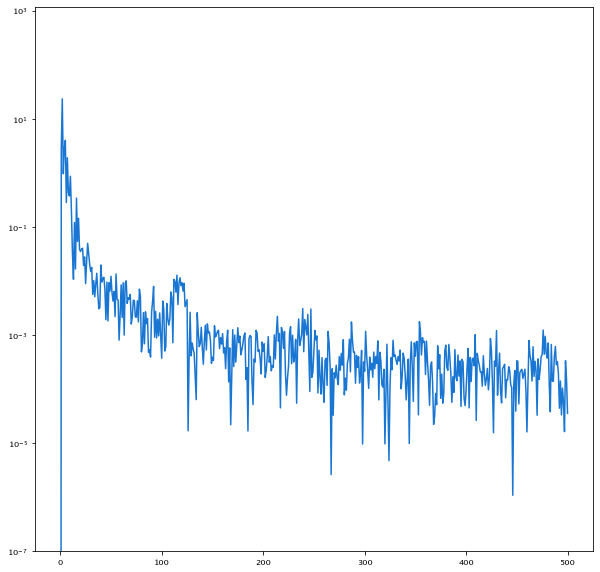

In [9]:
# plotting the PSD of just one dimension, expecting an f^-2 power law
plt.figure(figsize=(10,10))
plt.semilogy(*signal.periodogram(tt_cms[:,1], f_sampling))
plt.ylim(1e-7)

Now let's do the same exact thing but with least-squares.

In [10]:
basis_t = np.array(tt)
basis = basis_t.T
# to_multiply translates from an uncorrected phase screen to one with only TT uncorrected
to_multiply = basis.dot(np.linalg.inv(basis_t.dot(basis)).dot(basis_t))

In [11]:
tt_cms_ls = np.zeros((f_sampling * T, 2))
for n in range(f_sampling * T):
    layer.evolve_until(times[n])
    wf = layer(Wavefront(aperture, wavelength))
    tt_wf = Wavefront(aperture * np.exp(1j * to_multiply.dot(wf.phase) * scale), wavelength)
    tt_cms_ls[n] = center_of_mass(prop(tt_wf).intensity)
    
tt_cms_ls *= conversion

Text(0.5, 1.0, 'Atmospheric tip-tilts (LS)')

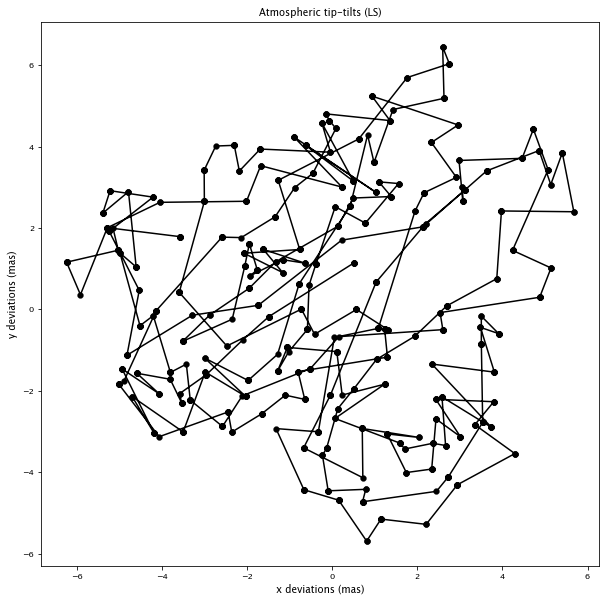

In [12]:
plt.figure(figsize=(10,10))
plt.plot(tt_cms_ls[:,0], tt_cms_ls[:,1], 'ko-')
plt.xlabel("x deviations (mas)")
plt.ylabel("y deviations (mas)")
plt.title("Atmospheric tip-tilts (LS)")

(1e-07, 119.96424705950862)

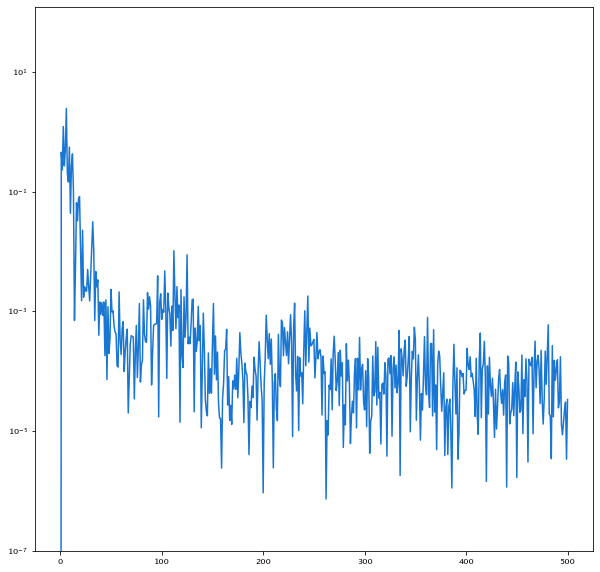

In [13]:
plt.figure(figsize=(10,10))
plt.semilogy(*signal.periodogram(tt_cms_ls[:,1], f_sampling))
plt.ylim(1e-7)

The two questions now are:
    
    1. Why is the least-squares PSD about 10x smaller than the mode basis one, and which one is accurate (if either of them are)?
    2. Why is it necessary to add the scaling factor to the pure tip/tilt Zernike phase screens to create one lambda/D movement, or where does the scaling factor come from?